# Library Data Contest 2019
**Authors:** Haleh Ale-Ahmand, Moein Hosseini<br/>
March 2019

**QUESTIONS:**<br/>
1. Are citations subset of traffic stops? <br/>
'When a traffic stop is made, a warning issued by the officer is a statement that the motorist has committed some offense, but is being spared the actual citation.'

## 0. PACKAGES AND FUNCTIONS

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pytz
from datetime import datetime
import seaborn as sns
import calendar

In [2]:
def replace_time(row):
    return row['Date_Object'].replace(hour = row['Hour'], minute = row['Minute'])

# 1. READ DATA

## 1.1 Evanston Citations<br/>
'Citations issued by officers during their tour of duty, excluding parking citations.'

In [3]:
citations_df = pd.read_csv('./Data/Evanston_Citations.csv')
citations_df.head(5)

,Citation Number,Citation Date,Citation Time,Day of the Week,Age,Race,Sex,Police Beat
0,YW341477,04/04/2031 12:00:00 AM,803.0,Fri,42.0,White,Female,NaN
1,YW436498,08/08/2020 12:00:00 AM,1839.0,Sat,38.0,Asian,Female,NaN
2,SE588873,03/22/2019 12:00:00 AM,908.0,Fri,55.0,White,Female,NaN
3,SE588869,03/22/2019 12:00:00 AM,831.0,Fri,67.0,White,Female,NaN
4,SE588925,03/22/2019 12:00:00 AM,1804.0,Fri,38.0,Black,Male,NaN


In [4]:
citations_df.shape[0]

24815

## 1.2 Evanston Traffic Stops

In [5]:
stops_df = pd.read_csv('./Data/Traffic_Stops_in_Evanston.csv')
stops_df.head(5)

,rpmainid,Stop Date,Stop Time,Day of the Week,Age,Race,Sex,Street Number,Street Name,Police Beat
0,45963,03/23/2019 12:00:00 AM,20,Sat,22.0,White,Female,800,LINCOLN ST,76.0
1,45953,03/22/2019 12:00:00 AM,1800,Fri,67.0,White,Female,500,CHICAGO AV/SOUTH BL,72.0
2,45954,03/22/2019 12:00:00 AM,1752,Fri,38.0,White,Male,800,RIDGE AV/WASHINGTON ST,71.0
3,45924,03/22/2019 12:00:00 AM,1048,Fri,19.0,Black,Male,900,MULFORD ST/RIDGE AV,78.0
4,45915,03/22/2019 12:00:00 AM,1036,Fri,67.0,Black,Male,100,BARTON AV/HOWARD ST,78.0


In [6]:
stops_df.shape[0]

35965

## 1.3 Evanston Crashes

In [7]:
crashes_df = pd.read_csv('./Data/Evanston_Traffic_Crashes.csv')
crashes_df.head(5)

,Accident ID (FK),Day of the Week,Accident Date,Accident Time,Accident Street Name,Direction from Intersecting Road,GEO-X,GEO-Y,Police Beat
0,19002236,Thu,03/21/2019,740,RIDGE,NaN,0,0,NaN
1,19002255,Thu,03/21/2019,1630,DEMPSTER,NaN,0,0,NaN
2,19002238,Thu,03/21/2019,940,FOWLER AV,NaN,0,0,NaN
3,19002251,Thu,03/21/2019,1544,JUDSON AVE,NaN,0,0,NaN
4,19002237,Thu,03/21/2019,749,CRAIN,NaN,0,0,NaN


# 2. Data Preprocessing

## 1.1 Evanston Citations

In [8]:
citations_df.isna().sum()

Citation Number        1
Citation Date          1
Citation Time          1
Day of the Week        1
Age                   49
Race                1512
Sex                   50
Police Beat        20842
dtype: int64

In [9]:
# Drop 'Police Beat'
citations_df.drop(['Police Beat'], axis = 1, inplace= True)
# Number of rows
print(len(citations_df.index))

24815


In [10]:
# Remove NAs
citations_df.dropna(subset = ['Citation Number', 'Citation Time', 'Day of the Week'], inplace= True)
# Number of rows
print(len(citations_df.index))

24814


In [11]:
# number of negative ages
print(citations_df['Age'][citations_df['Age'] < 0].size)
# Remove Negative Age
citations_df = citations_df.loc[np.logical_not(citations_df['Age'] < 0), :]
# Number of rows
print(len(citations_df.index))

1
24813


## 1.2 Evanston Traffic Stops

In [12]:
stops_df.isna().sum()

rpmainid              0
Stop Date             0
Stop Time             0
Day of the Week       0
Age                 203
Race                227
Sex                   0
Street Number      2763
Street Name           0
Police Beat        9410
dtype: int64

In [13]:
# Drop 'Police Beat'
stops_df.drop(['Police Beat'], axis = 1, inplace= True)
# Number of rows
print(len(stops_df.index))

35965


In [14]:
# number of negative ages
print(stops_df['Age'][stops_df['Age'] < 0].size)
# Remove Negative Age
stops_df = stops_df.loc[np.logical_not(stops_df['Age'] < 0), :]
# Number of rows
print(len(stops_df.index))

0
35965


# 2. Datetime
## 2.1 Evanston Citations
What are the types of the columns?

In [15]:
citations_df.dtypes

Citation Number     object
Citation Date       object
Citation Time      float64
Day of the Week     object
Age                float64
Race                object
Sex                 object
dtype: object

In [16]:
# Date
citations_df['Date_Object'] = pd.to_datetime(citations_df['Citation Date'], format = '%m/%d/%Y %H:%M:%S %p')

Time in `Citation Date` is not correct. We need to modify it using `Citation Time`. First, change citation time to integer and then to string:

In [17]:
citations_df['Citation Time'] = citations_df['Citation Time'].astype(int).astype(str)
# MINUTE
citations_df['Minute']= citations_df['Citation Time'].apply(lambda x: int(x[-2:]))
# HOUR
citations_df['Hour']  = citations_df['Citation Time'].apply(lambda x: x[:-2])
print(citations_df['Hour'].unique())
# hour 0 would be blank.
citations_df.loc[citations_df['Hour'] == '', ['Hour']] = '0'
citations_df['Hour'] = citations_df['Hour'].astype(int)

# Month 
citations_df['Month'] = citations_df['Date_Object'].map(lambda x : calendar.month_abbr[x.month])

# Year
citations_df['Year'] = citations_df['Date_Object'].map(lambda x : x.year)

# weekday
citations_df['Weekdays'] = citations_df['Day of the Week'].map({"Sat": "Weekend", "Sun": "Weekend", 
                                                                "Mon": "Weekday", "Tue": "Weekday", "Wed": "Weekday", "Thu": "Weekday", "Fri" : "Weekday"})

['8' '18' '9' '7' '16' '12' '11' '6' '21' '14' '10' '15' '17' '13' '5' '3'
 '4' '22' '' '19' '1' '23' '20' '2' '31' '32' '71']


Find the index of unacceptable *Hours*:

In [18]:
citations_df.loc[citations_df['Hour'] > 24,:]

,Citation Number,Citation Date,Citation Time,Day of the Week,Age,Race,Sex,Date_Object,Minute,Hour,Month,Year,Weekdays
3766,SE586258,11/11/2018 12:00:00 AM,3130,Sun,30.0,Black,Female,2018-11-11 12:00:00,30,31,Nov,2018,Weekend
5303,SE585335,09/27/2018 12:00:00 AM,3218,Thu,63.0,Black,Male,2018-09-27 12:00:00,18,32,Sep,2018,Weekday
8794,E200875,05/17/2018 12:00:00 AM,7159,Thu,49.0,White,Female,2018-05-17 12:00:00,59,71,May,2018,Weekday


Find the index of unacceptable *Minute*:

In [19]:
citations_df.loc[citations_df['Minute'] > 59,:]

,Citation Number,Citation Date,Citation Time,Day of the Week,Age,Race,Sex,Date_Object,Minute,Hour,Month,Year,Weekdays
488,SE588507,03/13/2019 12:00:00 AM,1690,Wed,79.0,Black,Female,2019-03-13 12:00:00,90,16,Mar,2019,Weekday
1107,SE588021,02/21/2019 12:00:00 AM,163,Thu,38.0,Asian,Female,2019-02-21 12:00:00,63,1,Feb,2019,Weekday
3359,SE586523,11/21/2018 12:00:00 AM,85,Wed,62.0,White,Male,2018-11-21 12:00:00,85,0,Nov,2018,Weekday


Remove the rows with unacceptale *Hour* and *Minute* and update *DateTime* object:

In [20]:
citations_df = citations_df[(0 <= citations_df['Minute']) & (citations_df['Minute']<= 59) &
                            (0 <= citations_df['Hour'])   & (citations_df['Hour']  <= 24) &
                            (citations_df['Year']  <= 2019)]
citations_df['DateTime_Object'] = citations_df.apply(replace_time, axis = 1)
citations_df.head(5)

,Citation Number,Citation Date,Citation Time,Day of the Week,Age,Race,Sex,Date_Object,Minute,Hour,Month,Year,Weekdays,DateTime_Object
2,SE588873,03/22/2019 12:00:00 AM,908,Fri,55.0,White,Female,2019-03-22 12:00:00,8,9,Mar,2019,Weekday,2019-03-22 09:08:00
3,SE588869,03/22/2019 12:00:00 AM,831,Fri,67.0,White,Female,2019-03-22 12:00:00,31,8,Mar,2019,Weekday,2019-03-22 08:31:00
4,SE588925,03/22/2019 12:00:00 AM,1804,Fri,38.0,Black,Male,2019-03-22 12:00:00,4,18,Mar,2019,Weekday,2019-03-22 18:04:00
5,SE588862,03/22/2019 12:00:00 AM,734,Fri,59.0,White,Male,2019-03-22 12:00:00,34,7,Mar,2019,Weekday,2019-03-22 07:34:00
6,SE588922,03/22/2019 12:00:00 AM,1801,Fri,67.0,White,Female,2019-03-22 12:00:00,1,18,Mar,2019,Weekday,2019-03-22 18:01:00


## 2.2 Evanston Traffic Stops

In [21]:
stops_df.head(5)

,rpmainid,Stop Date,Stop Time,Day of the Week,Age,Race,Sex,Street Number,Street Name
0,45963,03/23/2019 12:00:00 AM,20,Sat,22.0,White,Female,800,LINCOLN ST
1,45953,03/22/2019 12:00:00 AM,1800,Fri,67.0,White,Female,500,CHICAGO AV/SOUTH BL
2,45954,03/22/2019 12:00:00 AM,1752,Fri,38.0,White,Male,800,RIDGE AV/WASHINGTON ST
3,45924,03/22/2019 12:00:00 AM,1048,Fri,19.0,Black,Male,900,MULFORD ST/RIDGE AV
4,45915,03/22/2019 12:00:00 AM,1036,Fri,67.0,Black,Male,100,BARTON AV/HOWARD ST


In [22]:
# Date
stops_df['Date_Object'] = pd.to_datetime(stops_df['Stop Date'], format = '%m/%d/%Y %H:%M:%S %p')

#Time
stops_df['Stop Time'] = stops_df['Stop Time'].astype(int).astype(str)

# MINUTE
stops_df['Minute']= stops_df['Stop Time'].apply(lambda x: int(x[-2:]))

# HOUR
stops_df['Hour']  = stops_df['Stop Time'].apply(lambda x: x[:-2])
print(stops_df['Hour'].unique())
# hour 0 would be blank.
stops_df.loc[stops_df['Hour'] == '', ['Hour']] = '0'
stops_df['Hour'] = stops_df['Hour'].astype(int)

# Month 
stops_df['Month'] = stops_df['Date_Object'].map(lambda x : calendar.month_abbr[x.month])

# Year
stops_df['Year'] = stops_df['Date_Object'].map(lambda x : x.year)

# weekday
stops_df['Weekdays'] = stops_df['Day of the Week'].map({"Sat": "Weekend", "Sun": "Weekend", 
                                                                "Mon": "Weekday", "Tue": "Weekday", "Wed": "Weekday", "Thu": "Weekday", "Fri" : "Weekday"})


['' '18' '17' '10' '8' '16' '12' '20' '11' '23' '9' '1' '21' '7' '15' '14'
 '6' '13' '19' '2' '22' '3' '4' '5']


In [23]:
stops_df = stops_df[(0 <= stops_df['Minute']) & (stops_df['Minute'] <= 59) &
                    (0 <= stops_df['Hour'])   & (stops_df['Hour']   <= 24) &
                    (stops_df['Year']  <= 2019)]
stops_df['DateTime_Object'] = stops_df.apply(replace_time, axis = 1)
stops_df.head(5)

,rpmainid,Stop Date,Stop Time,Day of the Week,Age,Race,Sex,Street Number,Street Name,Date_Object,Minute,Hour,Month,Year,Weekdays,DateTime_Object
0,45963,03/23/2019 12:00:00 AM,20,Sat,22.0,White,Female,800,LINCOLN ST,2019-03-23 12:00:00,20,0,Mar,2019,Weekend,2019-03-23 00:20:00
1,45953,03/22/2019 12:00:00 AM,1800,Fri,67.0,White,Female,500,CHICAGO AV/SOUTH BL,2019-03-22 12:00:00,0,18,Mar,2019,Weekday,2019-03-22 18:00:00
2,45954,03/22/2019 12:00:00 AM,1752,Fri,38.0,White,Male,800,RIDGE AV/WASHINGTON ST,2019-03-22 12:00:00,52,17,Mar,2019,Weekday,2019-03-22 17:52:00
3,45924,03/22/2019 12:00:00 AM,1048,Fri,19.0,Black,Male,900,MULFORD ST/RIDGE AV,2019-03-22 12:00:00,48,10,Mar,2019,Weekday,2019-03-22 10:48:00
4,45915,03/22/2019 12:00:00 AM,1036,Fri,67.0,Black,Male,100,BARTON AV/HOWARD ST,2019-03-22 12:00:00,36,10,Mar,2019,Weekday,2019-03-22 10:36:00


## 2.3 Evanston Crashes

In [24]:
crashes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5540 entries, 0 to 5539
Data columns (total 9 columns):
Accident ID (FK)                    5540 non-null int64
Day of the Week                     5540 non-null object
Accident Date                       5540 non-null object
Accident Time                       5540 non-null int64
Accident Street Name                5540 non-null object
Direction from Intersecting Road    754 non-null object
GEO-X                               5540 non-null int64
GEO-Y                               5540 non-null int64
Police Beat                         1562 non-null float64
dtypes: float64(1), int64(4), object(4)
memory usage: 389.6+ KB


In [25]:
# Date
crashes_df['Date_Object'] = pd.to_datetime(crashes_df['Accident Date'], format = '%m/%d/%Y')
crashes_df['DateTime_Object'] = crashes_df['Date_Object'].map(lambda x: datetime.combine(x, datetime.min.time()))
print(crashes_df['Date_Object'].dtype, crashes_df['Date_Object'].dtype)

#Time
crashes_df['Accident Time'] = crashes_df['Accident Time'].astype(int).astype(str)

# MINUTE
crashes_df['Minute']= crashes_df['Accident Time'].apply(lambda x: int(x[-2:]))

# HOUR
crashes_df['Hour']  = crashes_df['Accident Time'].apply(lambda x: x[:-2])
print(crashes_df['Hour'].unique())
# hour 0 would be blank.
crashes_df.loc[crashes_df['Hour'] == '', ['Hour']] = '0'
crashes_df['Hour'] = crashes_df['Hour'].astype(int)

# Month
crashes_df['Month'] = crashes_df['DateTime_Object'].map(lambda x : calendar.month_abbr[x.month])

# Year
crashes_df['Year'] = crashes_df['DateTime_Object'].map(lambda x : calendar.month_abbr[x.month])

datetime64[ns] datetime64[ns]
['7' '16' '9' '15' '13' '8' '3' '18' '10' '23' '21' '20' '17' '19' '2'
 '11' '14' '12' '22' '' '1' '5' '6' '4']


In [26]:
crashes_df = crashes_df[(0 <= crashes_df['Minute']) & (crashes_df['Minute']<= 59) &
                        (0 <= crashes_df['Hour'])   & (crashes_df['Hour']  <= 24)]
crashes_df['DateTime_Object'] = crashes_df.apply(replace_time, axis = 1)
crashes_df.head(5)

,Accident ID (FK),Day of the Week,Accident Date,Accident Time,Accident Street Name,Direction from Intersecting Road,GEO-X,GEO-Y,Police Beat,Date_Object,DateTime_Object,Minute,Hour,Month,Year
0,19002236,Thu,03/21/2019,740,RIDGE,NaN,0,0,NaN,2019-03-21,2019-03-21 07:40:00,40,7,Mar,Mar
1,19002255,Thu,03/21/2019,1630,DEMPSTER,NaN,0,0,NaN,2019-03-21,2019-03-21 16:30:00,30,16,Mar,Mar
2,19002238,Thu,03/21/2019,940,FOWLER AV,NaN,0,0,NaN,2019-03-21,2019-03-21 09:40:00,40,9,Mar,Mar
3,19002251,Thu,03/21/2019,1544,JUDSON AVE,NaN,0,0,NaN,2019-03-21,2019-03-21 15:44:00,44,15,Mar,Mar
4,19002237,Thu,03/21/2019,749,CRAIN,NaN,0,0,NaN,2019-03-21,2019-03-21 07:49:00,49,7,Mar,Mar


# 3. Visulalization

## 3.1 Hourly Distribution

### 3.1.1 Based on Gender

In [27]:
sns.set_palette(sns.hls_palette(l=.5, s=.9))

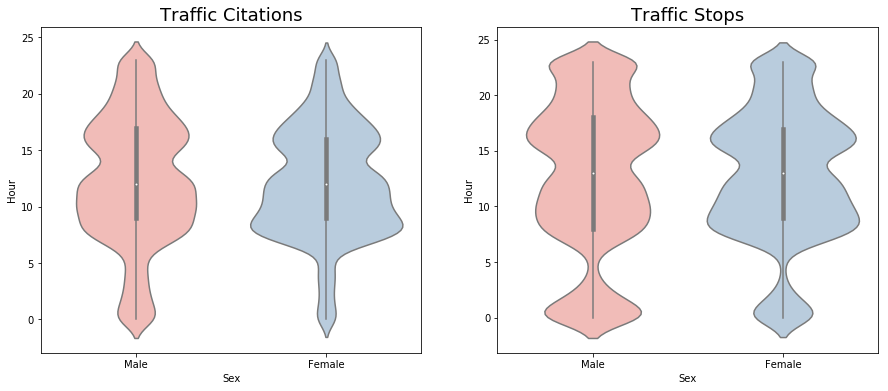

In [98]:
fig, axes = plt.subplots(figsize = (15, 6), nrows = 1, ncols = 2)
sns.violinplot(x= 'Sex', y= 'Hour', data = citations_df, ax = axes[0], palette = 'Pastel1',
              order = ['Male', 'Female'])
sns.violinplot(x= 'Sex', y= 'Hour', data = stops_df    , ax = axes[1], palette = 'Pastel1',
              order = ['Male', 'Female'])

axes[0].set_title('Traffic Citations', fontsize = 18)
axes[1].set_title('Traffic Stops', fontsize = 18)

fig.savefig('Plots/Fig01.png')

plt.show()

### 3.1.2 Based on day of week

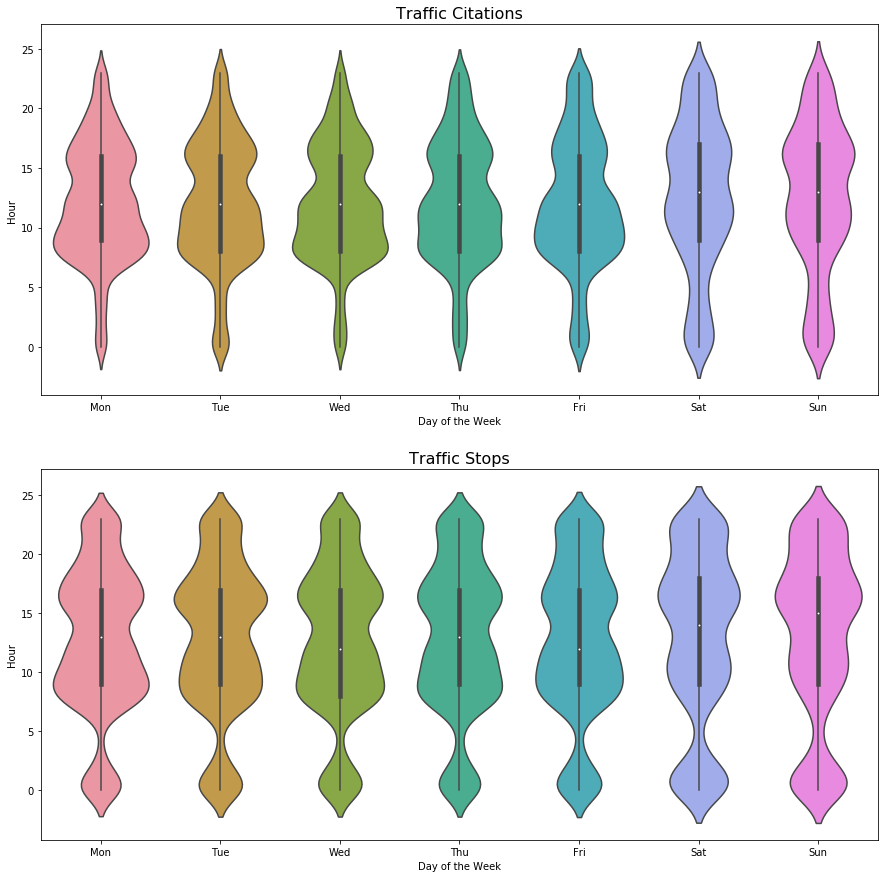

In [30]:


fig, axes = plt.subplots(figsize = (15, 15), nrows = 2, ncols = 1)
sns.violinplot(x= 'Day of the Week', y= 'Hour', data = citations_df, ax = axes[0],
               order=["Mon", "Tue", "Wed", 'Thu', 'Fri', 'Sat', 'Sun'])
sns.violinplot(x= 'Day of the Week', y= 'Hour', data = stops_df , ax = axes[1],
              order=["Mon", "Tue", "Wed", 'Thu', 'Fri', 'Sat', 'Sun'])


axes[0].set_title('Traffic Citations', fontsize = 16)
axes[1].set_title('Traffic Stops', fontsize = 16)

plt.show()

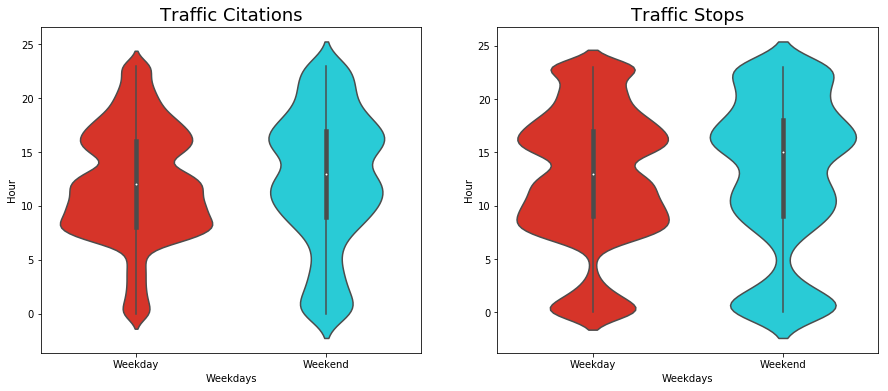

In [146]:
with sns.color_palette(sns.hls_palette(2, l=.5, s=.9)):
    fig, axes = plt.subplots(figsize = (15, 6), nrows = 1, ncols = 2)
    sns.violinplot(x= 'Weekdays', y= 'Hour', data = citations_df, ax = axes[0],
                   order=['Weekday', 'Weekend'])
    sns.violinplot(x= 'Weekdays', y= 'Hour', data = stops_df , ax = axes[1],
                  order=['Weekday', 'Weekend'])


    axes[0].set_title('Traffic Citations', fontsize = 18)
    axes[1].set_title('Traffic Stops', fontsize = 18)

    fig.savefig('Plots/Fig02.png')

    plt.show()

### 3.3 Based on Gender

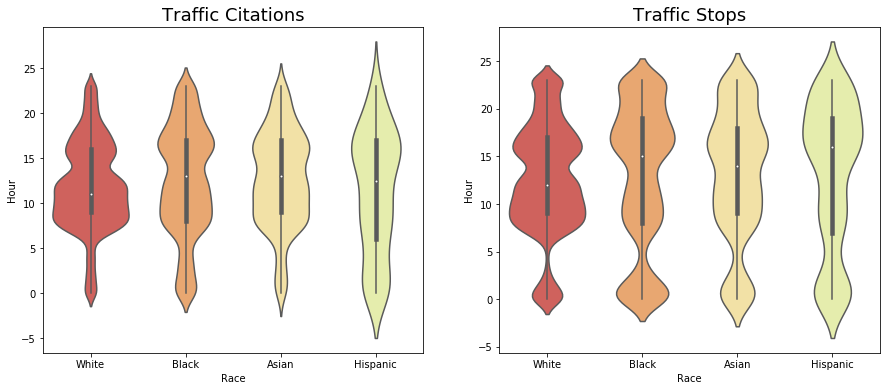

In [95]:
with sns.color_palette('Spectral'):

    fig, axes = plt.subplots(figsize = (15, 6), nrows = 1, ncols = 2)
    sns.violinplot(x= 'Race', y= 'Hour', data = citations_df, ax = axes[0],
                  order = ['White', 'Black', 'Asian', 'Hispanic'])
    sns.violinplot(x= 'Race', y= 'Hour', data = stops_df , ax = axes[1],
                  order = ['White', 'Black', 'Asian', 'Hispanic'])

    axes[0].set_title('Traffic Citations', fontsize = 18)
    axes[1].set_title('Traffic Stops', fontsize = 18)

    fig.savefig('Plots/Fig03.png')

    plt.show()

## 3.4 Based on Month

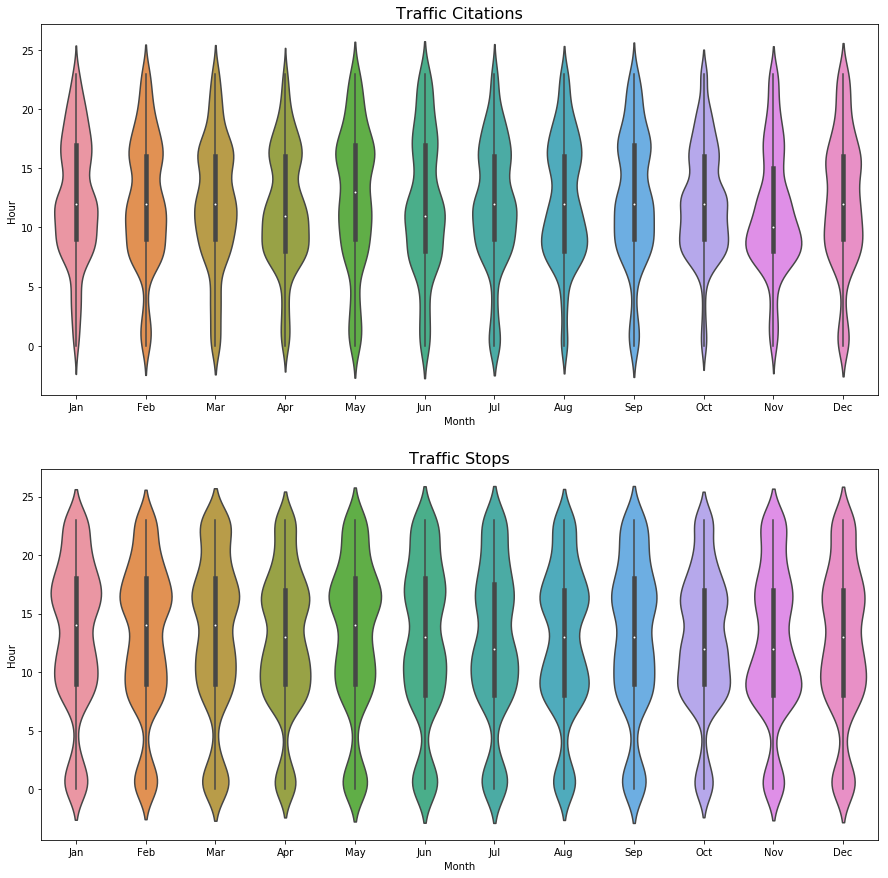

In [33]:
fig, axes = plt.subplots(figsize = (15, 15), nrows = 2, ncols = 1)
sns.violinplot(x= 'Month', y= 'Hour',
               data = citations_df[(citations_df.Year >= 2017) & (citations_df.Year <= 2018)],
               ax = axes[0],
               order = ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun',
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
sns.violinplot(x= 'Month', y= 'Hour', 
               data = stops_df[(stops_df.Year >= 2017) & (stops_df.Year <= 2018)] ,
               ax = axes[1],
              order = ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun',
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

axes[0].set_title('Traffic Citations', fontsize = 16)
axes[1].set_title('Traffic Stops', fontsize = 16)

plt.show()

## 3.2 Monthly Distribution

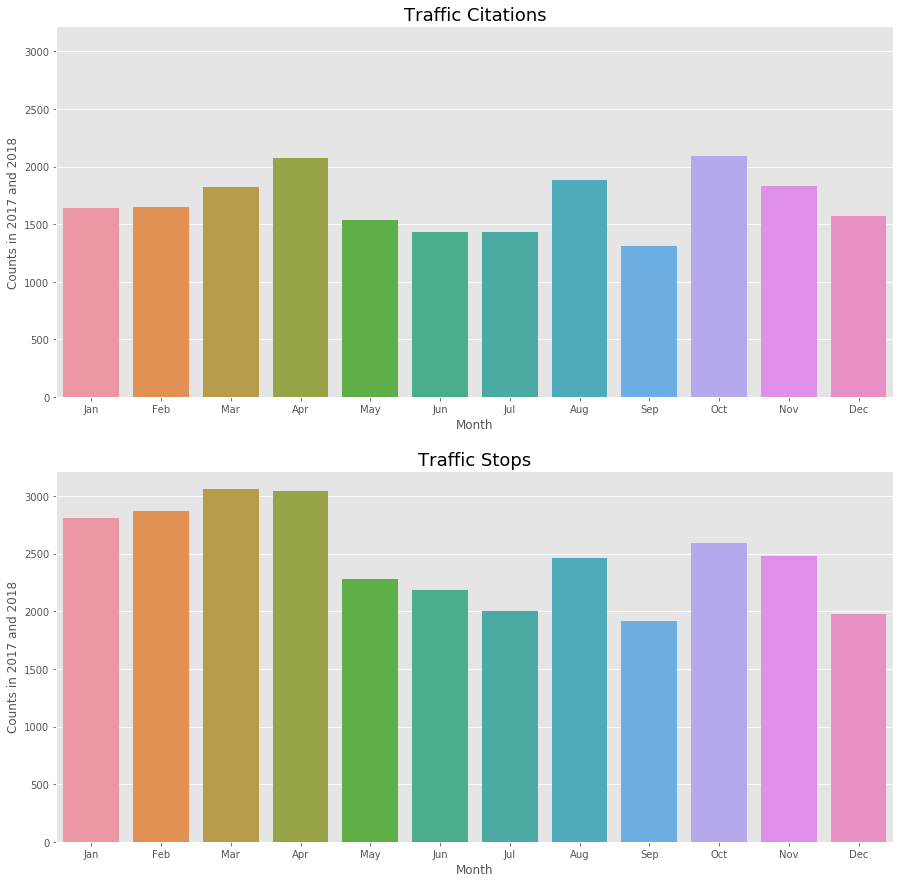

In [88]:
with plt.style.context('ggplot'):
    fig, axes = plt.subplots(figsize = (15,15), nrows = 2, ncols = 1, sharey = True)
    
    sns.countplot(x = 'Month',
                  data = citations_df[(citations_df['Year'] >= 2017) & (citations_df['Year'] <= 2018)], ax = axes[0], 
                 order = ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun',
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    sns.countplot(x = 'Month', 
                  data = stops_df[(stops_df['Year'] >= 2017) & (stops_df['Year'] <= 2018)], ax = axes[1],
                 order = ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun',
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    
    axes[0].set_title('Traffic Citations', fontsize = 18)
    axes[1].set_title('Traffic Stops', fontsize = 18)
    
    axes[0].set_ylabel('Counts in 2017 and 2018')
    axes[1].set_ylabel('Counts in 2017 and 2018')
    
    fig.savefig('Plots/Fig04.png')


 **Gender**

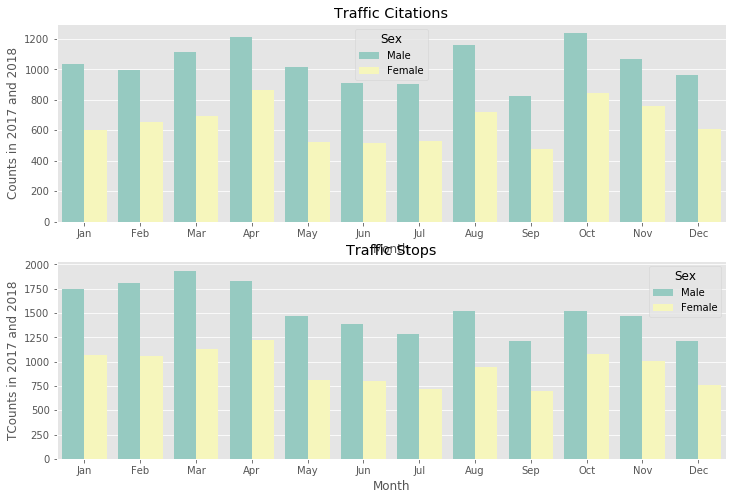

In [35]:
with plt.style.context('ggplot'):
    fig, axes = plt.subplots(figsize = (12,8), nrows = 2, ncols = 1)
    
    sns.countplot(x = 'Month', hue = 'Sex',
                  data = citations_df[(citations_df.Year >= 2017) & (citations_df.Year <= 2018)], ax = axes[0], 
                 order = ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun',
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
                 palette = 'Set3')
    sns.countplot(x = 'Month', hue = 'Sex', 
                  data = stops_df[(stops_df.Year >= 2017) & (stops_df.Year <= 2018)], ax = axes[1],
                 order = ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun',
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                 palette = 'Set3')
    
    axes[0].set_title('Traffic Citations')
    axes[1].set_title('Traffic Stops')
    
    axes[0].set_ylabel('Counts in 2017 and 2018')
    axes[1].set_ylabel('TCounts in 2017 and 2018')
    
    fig.savefig('Plots/Fig05.png')

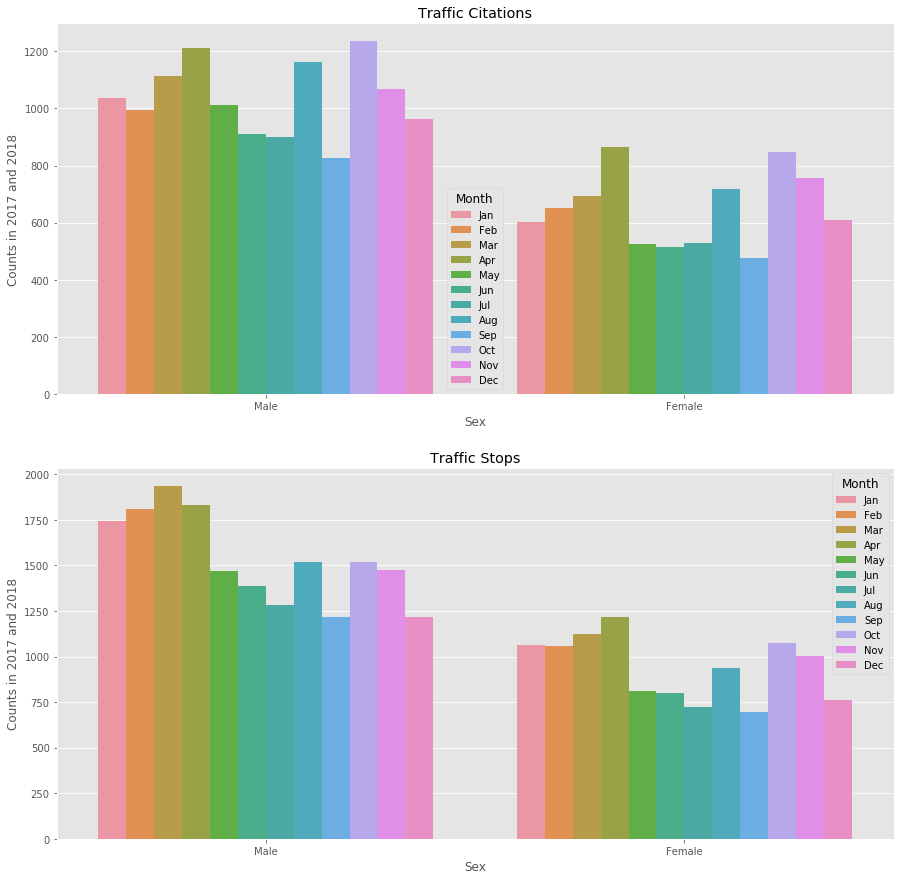

In [36]:
with plt.style.context('ggplot'):
    fig, axes = plt.subplots(figsize = (15,15), nrows = 2, ncols = 1)
        
    sns.countplot(x = 'Sex', hue = 'Month',
                  data = citations_df[(citations_df.Year >= 2017) & (citations_df.Year <= 2018)], ax = axes[0], 
                  hue_order = ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun',
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    sns.countplot(x = 'Sex', hue = 'Month', 
                  data = stops_df[(stops_df.Year >= 2017) & (stops_df.Year <= 2018)], ax = axes[1],
                  hue_order = ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun',
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    
    axes[0].set_title('Traffic Citations')
    axes[1].set_title('Traffic Stops')
    
    axes[0].set_ylabel('Counts in 2017 and 2018')
    axes[1].set_ylabel('Counts in 2017 and 2018')
    
    fig.savefig('Plots/Fig06.png')

**Race**

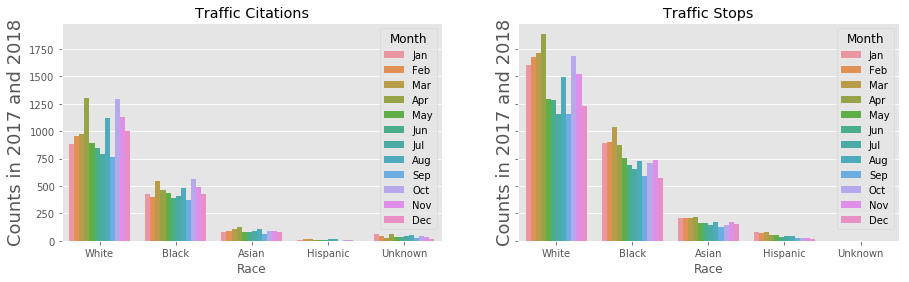

In [91]:
with plt.style.context('ggplot'):
    fig, axes = plt.subplots(figsize = (15,4), nrows = 1, ncols = 2, sharey = True)
    sns.countplot(x = 'Race', hue = 'Month',
                  data = citations_df[(citations_df.Year >= 2017) & (citations_df.Year <= 2018)], ax = axes[0], 
                  order = ['White', 'Black', 'Asian', 'Hispanic', 'Unknown'], 
                  hue_order = ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun',
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    sns.countplot(x = 'Race', hue = 'Month', 
                  data = stops_df[(stops_df.Year >= 2017) & (stops_df.Year <= 2018)], ax = axes[1],
                  order = ['White', 'Black', 'Asian', 'Hispanic', 'Unknown'], 
                  hue_order = ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun',
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    
    axes[0].set_title('Traffic Citations')
    axes[1].set_title('Traffic Stops')
    
    axes[0].set_ylabel('Counts in 2017 and 2018', fontsize = 18)
    axes[1].set_ylabel('Counts in 2017 and 2018', fontsize = 18)
    
    fig.savefig('Plots/Fig07.png')

## 3.2 Gender

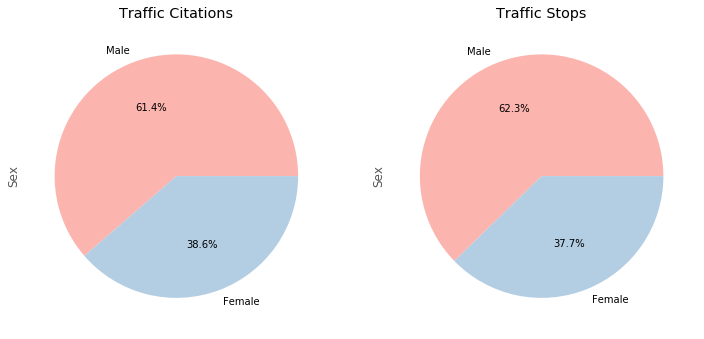

In [93]:
with plt.style.context('ggplot'):
    
    with sns.color_palette('Pastel1'):
    
        fig = plt.figure(figsize = (12,16))
        ax1 = fig.add_subplot(1, 2, 1)
        citations_df['Sex'].value_counts().plot(kind = 'pie', autopct = '%.1f%%', ax = ax1, title = 'Traffic Citations')

        ax2 = fig.add_subplot(1,2, 2)
        stops_df['Sex'].value_counts().plot(kind = 'pie', autopct = '%.1f%%', ax = ax2, title = 'Traffic Stops')
        
        axes[0].set_title('Traffic Citations', fontsize = 18)
        axes[1].set_title('Traffic Stops', fontsize = 18)

        fig.savefig('Plots/Fig08.png')
    

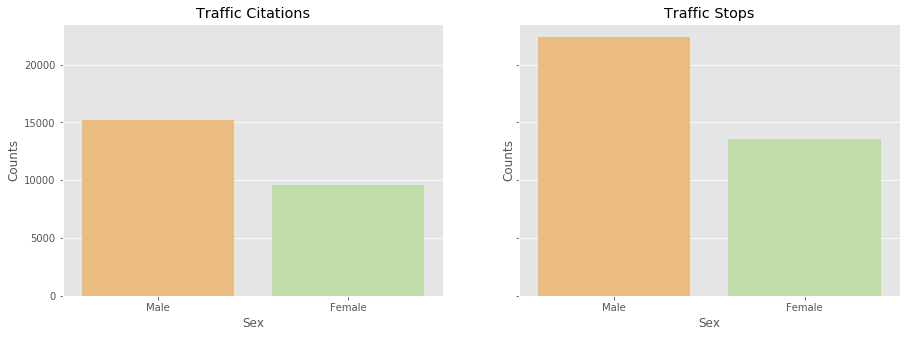

In [42]:
with plt.style.context('ggplot'):
    
    fig, axes = plt.subplots(figsize = (15,5), nrows = 1, ncols = 2, sharey = True)
    
    sns.countplot(x="Sex" , data = citations_df, ax = axes[0], palette = 'Spectral',
                 order = ['Male', 'Female'])
    sns.countplot(x="Sex" , data = stops_df,     ax = axes[1], palette = 'Spectral',
                 order = ['Male', 'Female'])
    
    axes[0].set_title('Traffic Citations')
    axes[1].set_title('Traffic Stops')
    
    axes[0].set_ylabel('Counts')
    axes[1].set_ylabel('Counts')
    
    fig.savefig('Plots/Fig09.png')

**GENDER AND RACE**

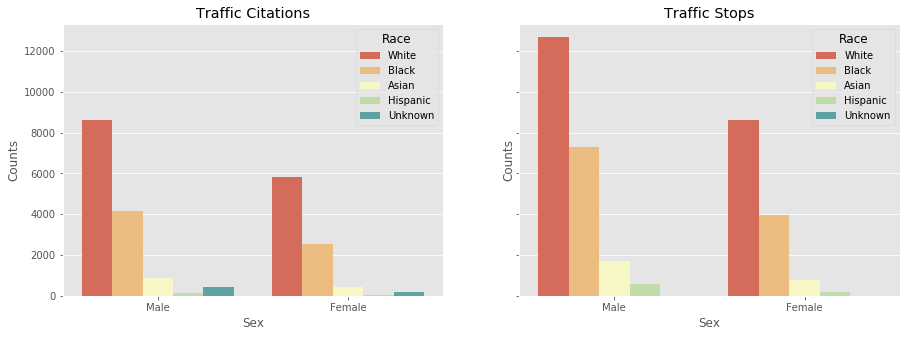

In [147]:
with plt.style.context('ggplot'):
    
    fig, axes = plt.subplots(figsize = (15,5), nrows = 1, ncols = 2, sharey = True)
    
    sns.countplot(x="Sex", hue= "Race" , data = citations_df, ax = axes[0], palette = 'Spectral',
                  order = ['Male', 'Female'],
                 hue_order = ['White', 'Black', 'Asian', 'Hispanic', 'Unknown'])
    sns.countplot(x="Sex", hue= "Race" , data = stops_df, ax = axes[1], palette = 'Spectral',
                  order = ['Male', 'Female'],
                 hue_order = ['White', 'Black', 'Asian', 'Hispanic', 'Unknown'])
    
    axes[0].set_title('Traffic Citations')
    axes[1].set_title('Traffic Stops')
    
    axes[0].set_ylabel('Counts')
    axes[1].set_ylabel('Counts')
    
    fig.savefig('Plots/Fig10.png')

# 3.3. Race

In [51]:
print(citations_df['Race'].unique())
print(stops_df['Race'].unique())

['White' 'Black' 'Asian' nan 'Unknown' 'Hispanic']
['White' 'Black' 'Asian' nan 'Hispanic' 'Unknown']


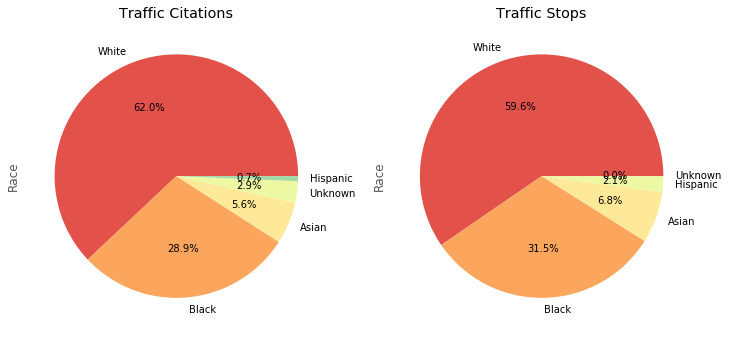

In [94]:
with plt.style.context('ggplot'):
    
    with sns.color_palette('Spectral'):
        fig = plt.figure( figsize = (12,16))
        ax1 = fig.add_subplot(1, 2, 1)
        citations_df['Race'].value_counts().plot(kind = 'pie', autopct = '%.1f%%', ax = ax1, title = 'Traffic Citations')

        ax2 = fig.add_subplot(1,2, 2)
        stops_df['Race'].value_counts().plot(kind = 'pie', autopct = '%.1f%%', ax = ax2, title = 'Traffic Stops')

        axes[0].set_title('Traffic Citations')
        axes[1].set_title('Traffic Stops')

        axes[0].set_ylabel('Counts in 2017 and 2018')
        axes[1].set_ylabel('Counts in 2017 and 2018')

        fig.savefig('Plots/Fig11.png')
    

**RACE AND GENDER**

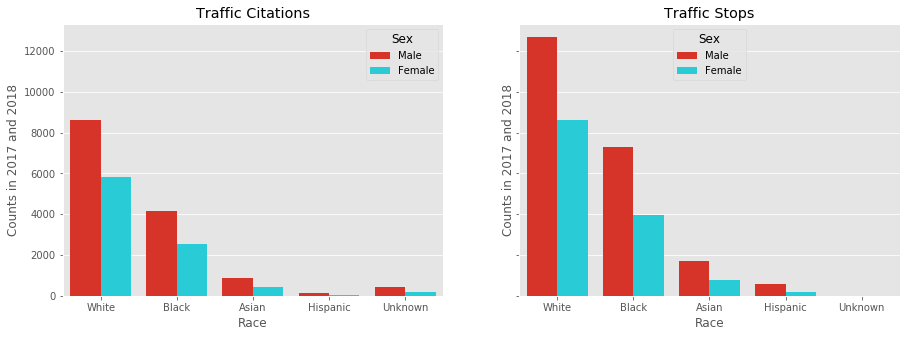

In [60]:
sns.set_palette(sns.hls_palette(2, l=.5, s=.9))
with plt.style.context('ggplot'):
    with sns.color_palette(sns.hls_palette(2, l=.5, s=.9)):
        fig, axes = plt.subplots(figsize = (15,5), nrows = 1, ncols = 2, sharey = True)

        sns.countplot(x="Race", hue= "Sex" , data = citations_df, ax = axes[0], 
                     order = ['White', 'Black', 'Asian', 'Hispanic', 'Unknown'],
                     hue_order = ['Male', 'Female'])
        sns.countplot(x="Race", hue= "Sex" , data = stops_df, ax = axes[1],
                     order = ['White', 'Black', 'Asian', 'Hispanic', 'Unknown'],
                     hue_order = ['Male', 'Female'])
        
    axes[0].set_title('Traffic Citations')
    axes[1].set_title('Traffic Stops')
    
    axes[0].set_ylabel('Counts in 2017 and 2018')
    axes[1].set_ylabel('Counts in 2017 and 2018')
    
    fig.savefig('Plots/Fig12.png')


# 3.4. Age

In [58]:
# Citations
citations_df['Age'].describe()

# Traffic Stops

count    24757.000000
mean        39.451428
std         15.411822
min          0.000000
25%         27.000000
50%         37.000000
75%         51.000000
max         94.000000
Name: Age, dtype: float64

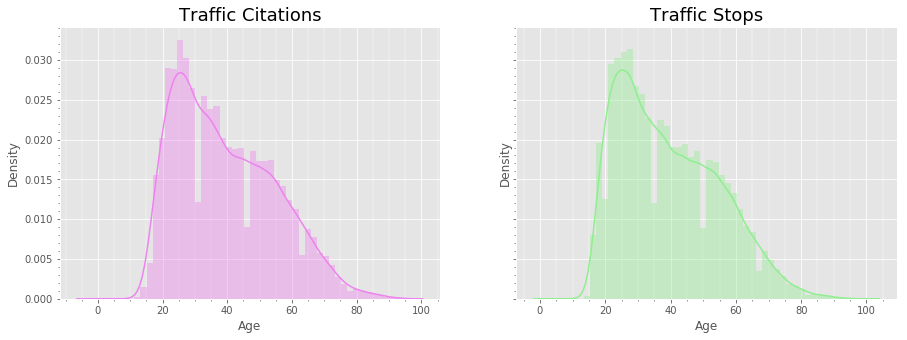

In [137]:
with plt.style.context('ggplot'):
        fig, axes = plt.subplots(figsize = (15,5), ncols = 2, nrows = 1, sharey = True)

        sns.distplot(citations_df['Age'].dropna(),  ax  = axes[0], color = 'violet')
        axes[0].minorticks_on()
        axes[0].xaxis.grid(b=True, which='minor', color='w', linewidth = 0.4)

        sns.distplot(stops_df['Age'].dropna(),  ax  = axes[1], color = 'lightgreen')
        axes[1].minorticks_on()
        axes[1].xaxis.grid(b=True, which='minor', color='w', linewidth = 0.4)

        axes[0].set_title('Traffic Citations', fontsize = 18)
        axes[1].set_title('Traffic Stops', fontsize = 18)

        axes[0].set_ylabel('Density')
        axes[1].set_ylabel('Density')

        fig.savefig('Plots/Fig13.png')

**AGE AND RACE**

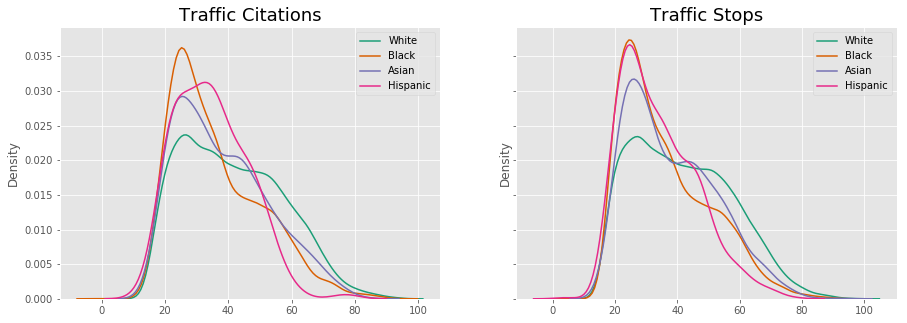

In [101]:
with plt.style.context('ggplot'):
    with sns.color_palette('Dark2'):
    
        fig, axes = plt.subplots(1,2, figsize= (15,5), sharey = True)
        p1 = sns.kdeplot(citations_df.loc[citations_df['Race'] == 'White', 'Age'].dropna(), label = 'White', ax = axes[0])
        p1 = sns.kdeplot(citations_df.loc[citations_df['Race'] == 'Black', 'Age'].dropna(), label = 'Black', ax = axes[0])
        p1 = sns.kdeplot(citations_df.loc[citations_df['Race'] == 'Asian', 'Age'].dropna(), label = 'Asian', ax = axes[0])
        p1 = sns.kdeplot(citations_df.loc[citations_df['Race'] == 'Hispanic', 'Age'].dropna(), label = 'Hispanic', ax = axes[0])

        p2 = sns.kdeplot(stops_df.loc[stops_df['Race'] == 'White', 'Age'].dropna(), label = 'White', ax = axes[1])
        p2 = sns.kdeplot(stops_df.loc[stops_df['Race'] == 'Black', 'Age'].dropna(), label = 'Black', ax = axes[1])
        p2 = sns.kdeplot(stops_df.loc[stops_df['Race'] == 'Asian', 'Age'].dropna(), label = 'Asian', ax = axes[1])
        p2 = sns.kdeplot(stops_df.loc[stops_df['Race'] == 'Hispanic', 'Age'].dropna(), label = 'Hispanic', ax = axes[1])

        axes[0].set_title('Traffic Citations', fontsize = 18)
        axes[1].set_title('Traffic Stops', fontsize = 18)

        axes[0].set_ylabel('Density')
        axes[1].set_ylabel('Density')

        fig.savefig('Plots/Fig14.png')
    

**AGE AND GENDER**

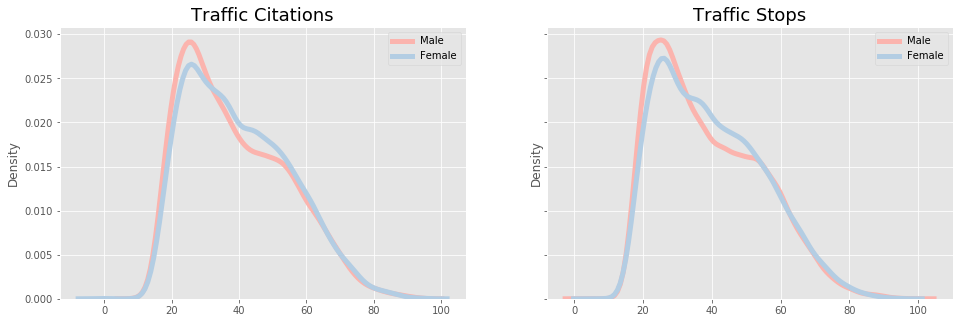

In [109]:
with plt.style.context('ggplot'):
    with sns.color_palette('Pastel1'):
    
        fig, axes = plt.subplots(1,2, figsize= (16,5), sharey = True)
        p1 = sns.kdeplot(citations_df.loc[citations_df['Sex'] == 'Male', 'Age'].dropna(), label = 'Male', 
                         ax = axes[0], linewidth = 5)
        p1 = sns.kdeplot(citations_df.loc[citations_df['Sex'] == 'Female', 'Age'].dropna(), label = 'Female', 
                         ax = axes[0], linewidth = 5)

        p2 = sns.kdeplot(stops_df.loc[stops_df['Sex'] == 'Male', 'Age'].dropna(), label = 'Male',
                         ax = axes[1], linewidth = 5)
        p2 = sns.kdeplot(stops_df.loc[stops_df['Sex'] == 'Female', 'Age'].dropna(), label = 'Female', 
                         ax = axes[1], linewidth = 5)
        
        axes[0].set_title('Traffic Citations', fontsize = 18)
        axes[1].set_title('Traffic Stops', fontsize = 18)
    
        axes[0].set_ylabel('Density')
        axes[1].set_ylabel('Density')

        fig.savefig('Plots/Fig15.png')

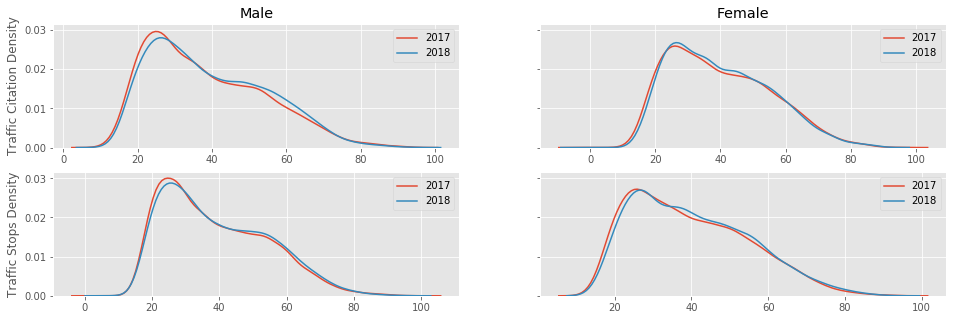

In [71]:
with plt.style.context('ggplot'):
    
    fig, axes = plt.subplots(2,2, figsize= (16,5), sharey = True)
    p1 = sns.kdeplot(citations_df.loc[(citations_df['Sex'] == 'Male') & (citations_df['Year'] == 2017), 'Age'].dropna(), 
                     label = '2017', ax = axes[0,0])
    p1 = sns.kdeplot(citations_df.loc[(citations_df['Sex'] == 'Male') & (citations_df['Year'] == 2018), 'Age'].dropna(), 
                     label = '2018', ax = axes[0,0])
    
    p2 = sns.kdeplot(citations_df.loc[(citations_df['Sex'] == 'Female') & (citations_df['Year'] == 2017), 'Age'].dropna(), 
                     label = '2017', ax = axes[0,1])
    p2 = sns.kdeplot(citations_df.loc[(citations_df['Sex'] == 'Female') & (citations_df['Year'] == 2018), 'Age'].dropna(), 
                     label = '2018', ax = axes[0,1])
    
    p3 = sns.kdeplot(stops_df.loc[(stops_df['Sex'] == 'Male') & (stops_df['Year'] == 2017), 'Age'].dropna(), 
                     label = '2017', ax = axes[1,0])
    p3 = sns.kdeplot(stops_df.loc[(stops_df['Sex'] == 'Male') & (stops_df['Year'] == 2018), 'Age'].dropna(), 
                     label = '2018', ax = axes[1,0])
    
    p4 = sns.kdeplot(stops_df.loc[(stops_df['Sex'] == 'Female') & (stops_df['Year'] == 2017), 'Age'].dropna(), 
                     label = '2017', ax = axes[1,1])
    p4 = sns.kdeplot(stops_df.loc[(stops_df['Sex'] == 'Female') & (stops_df['Year'] == 2018), 'Age'].dropna(), 
                     label = '2018', ax = axes[1,1])
    
    axes[0,0].set_title('Male')
    axes[0,1].set_title('Female')

    axes[0,0].set_ylabel('Traffic Citation Density')
    axes[1,0].set_ylabel('Traffic Stops Density')
    
    fig.savefig('Plots/Fig16.png')


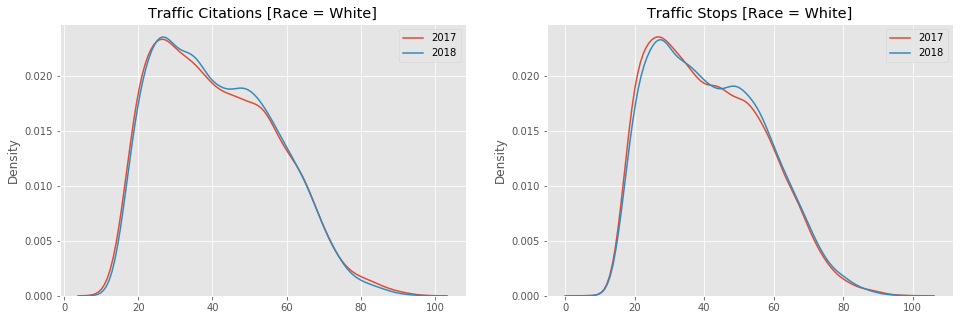

In [141]:
with plt.style.context('ggplot'):
    
    fig, axes = plt.subplots(1,2, figsize= (16,5))
    p1 = sns.kdeplot(citations_df.loc[(citations_df['Race'] == 'White') & (citations_df['Year'] == 2017), 'Age'].dropna(), label = '2017', ax = axes[0])
    p1 = sns.kdeplot(citations_df.loc[(citations_df['Race'] == 'White') & (citations_df['Year'] == 2018), 'Age'].dropna(), label = '2018', ax = axes[0])
    
    p2 = sns.kdeplot(stops_df.loc[(stops_df['Race'] == 'White') & (stops_df['Year'] == 2017), 'Age'].dropna(), label = '2017', ax = axes[1])
    p2 = sns.kdeplot(stops_df.loc[(stops_df['Race'] == 'White') & (stops_df['Year'] == 2018), 'Age'].dropna(), label = '2018', ax = axes[1])

    axes[0].set_title('Traffic Citations [Race = White]')
    axes[1].set_title('Traffic Stops [Race = White]')

    axes[0].set_ylabel('Density')
    axes[1].set_ylabel('Density')
    
    fig.savefig('Plots/Fig17.png')


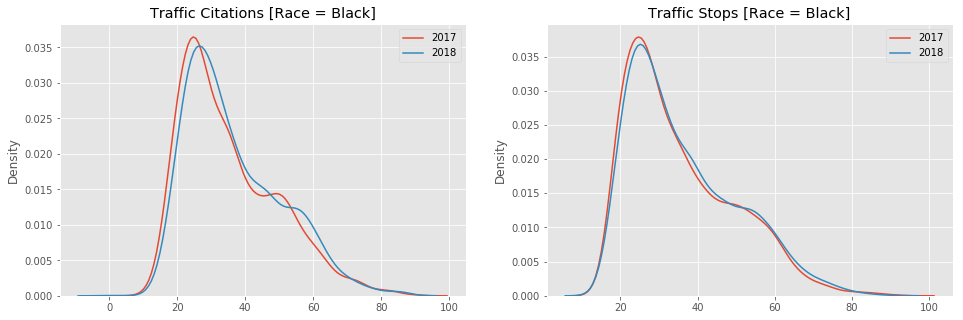

In [142]:
with plt.style.context('ggplot'):
    
    fig, axes = plt.subplots(1,2, figsize= (16,5))
    p1 = sns.kdeplot(citations_df.loc[(citations_df['Race'] == 'Black') & (citations_df['Year'] == 2017), 'Age'].dropna(), label = '2017', ax = axes[0])
    p1 = sns.kdeplot(citations_df.loc[(citations_df['Race'] == 'Black') & (citations_df['Year'] == 2018), 'Age'].dropna(), label = '2018', ax = axes[0])
    
    p2 = sns.kdeplot(stops_df.loc[(stops_df['Race'] == 'Black') & (stops_df['Year'] == 2017), 'Age'].dropna(), label = '2017', ax = axes[1])
    p2 = sns.kdeplot(stops_df.loc[(stops_df['Race'] == 'Black') & (stops_df['Year'] == 2018), 'Age'].dropna(), label = '2018', ax = axes[1])

    axes[0].set_title('Traffic Citations')
    axes[1].set_title('Traffic Stops')

    axes[0].set_ylabel('Density')
    axes[1].set_ylabel('Density')
    
    axes[0].set_title('Traffic Citations [Race = Black]')
    axes[1].set_title('Traffic Stops [Race = Black]')

    axes[0].set_ylabel('Density')
    axes[1].set_ylabel('Density')
    
    fig.savefig('Plots/Fig18.png')



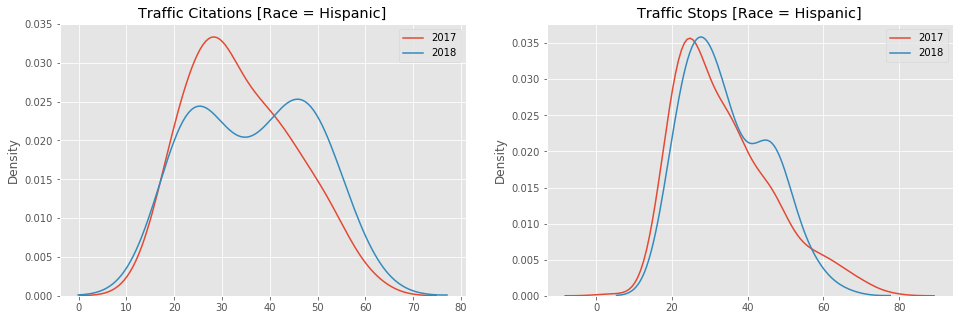

In [143]:
with plt.style.context('ggplot'):
    
    fig, axes = plt.subplots(1,2, figsize= (16,5))
    p1 = sns.kdeplot(citations_df.loc[(citations_df['Race'] == 'Hispanic') & (citations_df['Year'] == 2017), 'Age'].dropna(), 
                     label = '2017', ax = axes[0])
    p1 = sns.kdeplot(citations_df.loc[(citations_df['Race'] == 'Hispanic') & (citations_df['Year'] == 2018), 'Age'].dropna(), 
                     label = '2018', ax = axes[0])
    
    p2 = sns.kdeplot(stops_df.loc[(stops_df['Race'] == 'Hispanic') & (stops_df['Year'] == 2017), 'Age'].dropna(), 
                     label = '2017', ax = axes[1])
    p2 = sns.kdeplot(stops_df.loc[(stops_df['Race'] == 'Hispanic') & (stops_df['Year'] == 2018), 'Age'].dropna(), 
                     label = '2018', ax = axes[1])
    
    axes[0].set_title('Traffic Citations [Race = Hispanic]')
    axes[1].set_title('Traffic Stops [Race = Hispanic]')

    axes[0].set_ylabel('Density')
    axes[1].set_ylabel('Density')
    
    fig.savefig('Plots/Fig19.png')


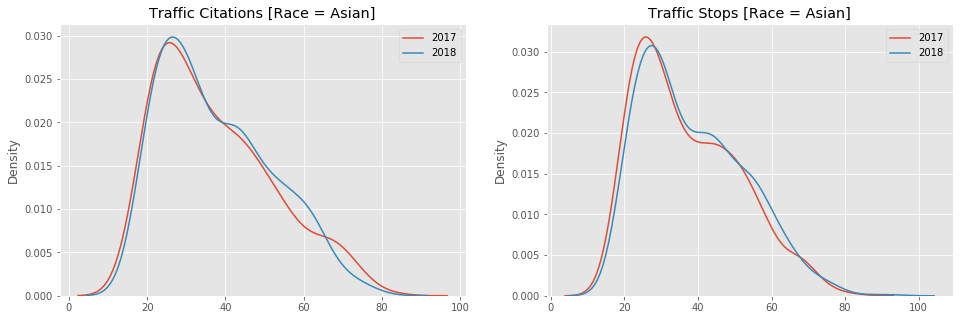

In [144]:
with plt.style.context('ggplot'):
    
    fig, axes = plt.subplots(1,2, figsize= (16,5))
    p1 = sns.kdeplot(citations_df.loc[(citations_df['Race'] == 'Asian') & (citations_df['Year'] == 2017), 'Age'].dropna(),
                     label = '2017', ax = axes[0])
    p1 = sns.kdeplot(citations_df.loc[(citations_df['Race'] == 'Asian') & (citations_df['Year'] == 2018), 'Age'].dropna(),
                     label = '2018', ax = axes[0])
    
    p2 = sns.kdeplot(stops_df.loc[(stops_df['Race'] == 'Asian') & (stops_df['Year'] == 2017), 'Age'].dropna(),
                     label = '2017', ax = axes[1])
    p2 = sns.kdeplot(stops_df.loc[(stops_df['Race'] == 'Asian') & (stops_df['Year'] == 2018), 'Age'].dropna(), 
                     label = '2018', ax = axes[1])
    
    axes[0].set_title('Traffic Citations [Race = Asian]')
    axes[1].set_title('Traffic Stops [Race = Asian]')

    axes[0].set_ylabel('Density')
    axes[1].set_ylabel('Density')
    
    fig.savefig('Plots/Fig20.png')


1) Age over weekend vs. weekdays (Day of week) <br/>

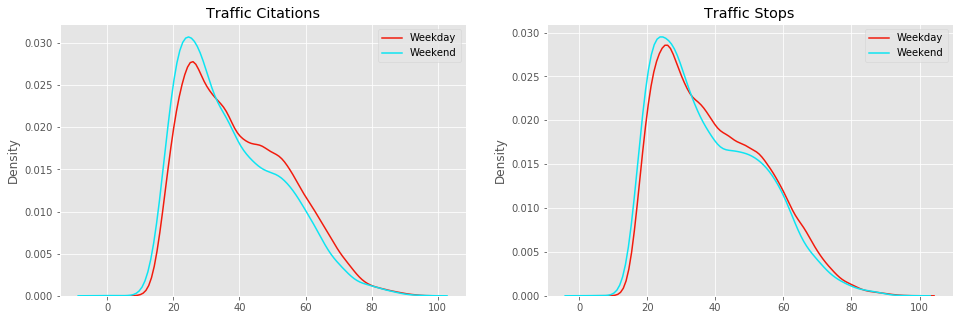

In [145]:
with plt.style.context('ggplot'):
    
    with sns.color_palette(sns.hls_palette(2, l=.5, s=.9)):
        fig, axes = plt.subplots(1,2, figsize= (16,5))
        p1 = sns.kdeplot(citations_df.loc[(citations_df['Weekdays'] == 'Weekday'), 'Age'].dropna(), label = 'Weekday', ax = axes[0])
        p1 = sns.kdeplot(citations_df.loc[(citations_df['Weekdays'] == 'Weekend'), 'Age'].dropna(), label = 'Weekend', ax = axes[0])

        p2 = sns.kdeplot(stops_df.loc[(stops_df['Weekdays'] == 'Weekday'), 'Age'].dropna(), label = 'Weekday', ax = axes[1])
        p2 = sns.kdeplot(stops_df.loc[(stops_df['Weekdays'] == 'Weekend'), 'Age'].dropna(), label = 'Weekend', ax = axes[1])

        axes[0].set_title('Traffic Citations')
        axes[1].set_title('Traffic Stops')

        axes[0].set_ylabel('Density')
        axes[1].set_ylabel('Density')

        fig.savefig('Plots/Fig21.png')
